In [935]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import Callable

In [936]:
torch.set_default_device('cuda' if torch.cuda.is_available() else 'cpu')
torch.get_default_device()

device(type='cuda', index=0)

In [937]:
nerf_data = np.load("./data/nerf-data/tiny_nerf_data.npz")
nerf_data.keys()

KeysView(NpzFile './data/nerf-data/tiny_nerf_data.npz' with keys: images, poses, focal)

In [938]:
input_images = torch.from_numpy(nerf_data["images"]).to(device=torch.get_default_device())
"""Training images"""
input_poses = torch.from_numpy(nerf_data["poses"]).to(device=torch.get_default_device())
"""Camera-to-world transformation matrices"""
focal_length = torch.from_numpy(nerf_data["focal"]).to(device=torch.get_default_device())
"""Distance from camera to image plane"""

image_resolution = input_images.shape[1:-1]

clip_near = 0.1
clip_far = 5.0

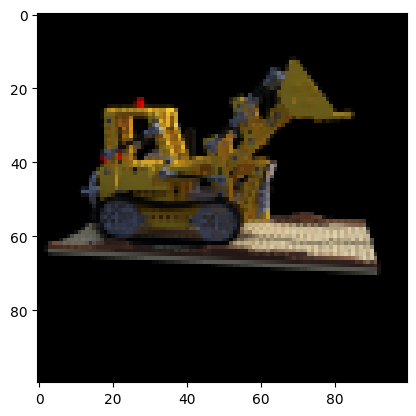

"Pose : tensor([[ 0.2079,  0.1652, -0.9641, -3.8864],\n        [-0.9781,  0.0351, -0.2049, -0.8261],\n        [ 0.0000,  0.9856,  0.1689,  0.6810],\n        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')"

In [939]:
sample_image_idx = input_images.shape[0] // 2
test_image, test_pose = input_images[sample_image_idx], input_poses[sample_image_idx]

plt.imshow(test_image.cpu().numpy())
plt.show()
f"Pose : {test_pose}"

\begin{align}
\gamma(x,y) =&[\sin(\pi x), \cos(\pi x),\sin(\pi y), \cos(\pi y), \\
&\sin(2 \pi x), \cos(2 \pi x),\sin(2 \pi y), \cos(2 \pi y), \\
&\ldots\\
&\sin(2^{L-1}\pi x), \cos(2^{L-1}\pi x),\sin(2^{L-1}\pi y), \cos(2^{L-1}\pi y)] \in \mathbb{R}^{4*L}
\end{align}

In [940]:
def positional_encoding(v : torch.Tensor, l : int = 6):
    # TESTED : OK
    # TODO : This is not ideal, ideally we implement this https://bmild.github.io/fourfeat/ 
    """
    Apply positional encoding (Gamma) to the input tensor
    Source : https://bmild.github.io/fourfeat/

    l - Low l over-smooths, high l over-fits
    """
    n = v.size
    
    powers = 2 ** torch.arange(l)  # Shape: (l,)
    
    # Calculate sin and cos components
    sin_values = torch.sin(torch.outer(powers, v) * torch.pi)  # Shape: (l, n)
    cos_values = torch.cos(torch.outer(powers, v) * torch.pi)  # Shape: (l, n)
    
    # Stack sin and cos values along the last axis and reshape
    result = torch.stack((sin_values,  cos_values), axis=-1).reshape(-1)

    return result

def positional_encode_batch(v: torch.Tensor, l: int = 6):
    """Apply positional encoding to a batch of vectors."""
    # Ensure input is on correct device
    device = v.device
    
    # Calculate frequencies for encoding
    freqs = 2.0 ** torch.arange(l, dtype=torch.float32, device=device)
    
    # Prepare input for broadcasting
    x_expanded = v[..., None] * freqs[None, None, :]  # Shape: (..., coord, L)
    
    # Calculate sin and cos values
    sin_vals = torch.sin(x_expanded * np.pi)
    cos_vals = torch.cos(x_expanded * np.pi)
    
    # Concatenate and reshape
    encoded = torch.stack([sin_vals, cos_vals], dim=-2)  # Shape: (..., coord, 2, L)
    encoded = encoded.view(*v.shape[:-1], -1)  # Flatten last dimensions
    
    return encoded

v1 = torch.tensor([2, 3])
v2 = torch.tensor([4, 5])

o1 = torch.stack((positional_encoding(v1),positional_encoding(v2)))
o2 = positional_encode_batch(torch.stack((v1, v2)))

o1.sum(), o2.sum(), o1, o2

(tensor(20.0001, device='cuda:0'),
 tensor(20.0001, device='cuda:0'),
 tensor([[ 1.7485e-07,  1.0000e+00, -2.3850e-08, -1.0000e+00,  3.4969e-07,
           1.0000e+00,  4.7700e-08,  1.0000e+00,  6.9938e-07,  1.0000e+00,
           9.5399e-08,  1.0000e+00,  1.3988e-06,  1.0000e+00,  1.9080e-07,
           1.0000e+00,  2.7975e-06,  1.0000e+00,  3.8160e-07,  1.0000e+00,
           5.5951e-06,  1.0000e+00,  7.6319e-07,  1.0000e+00],
         [ 3.4969e-07,  1.0000e+00, -6.7553e-07, -1.0000e+00,  6.9938e-07,
           1.0000e+00,  1.3511e-06,  1.0000e+00,  1.3988e-06,  1.0000e+00,
           2.7021e-06,  1.0000e+00,  2.7975e-06,  1.0000e+00,  5.4043e-06,
           1.0000e+00,  5.5951e-06,  1.0000e+00,  1.0809e-05,  1.0000e+00,
           1.1190e-05,  1.0000e+00,  2.1617e-05,  1.0000e+00]], device='cuda:0'),
 tensor([[ 1.7485e-07,  3.4969e-07,  6.9938e-07,  1.3988e-06,  2.7975e-06,
           5.5951e-06,  1.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
           1.0000e+00,  1.0000e+00,

In [941]:
class NerfModel(torch.nn.Module):
  def __init__(self, filter_size=128, l=6):
    super(NerfModel, self).__init__()
    self.l = l
    
    input_size = l * 2 * 3
    self.layer1 = torch.nn.Linear(input_size, filter_size)
    self.layer2 = torch.nn.Linear(filter_size, filter_size)
    self.layer3 = torch.nn.Linear(filter_size, 4)
    self.relu = torch.nn.functional.relu
  
  def forward(self, x):
    x = self.relu(self.layer1(x))
    x = self.relu(self.layer2(x))
    x = self.layer3(x)
    return x

In [942]:
def get_rays(image_resolution : np.ndarray, focal_length: float, mat_cam_to_world: torch.Tensor) -> torch.Tensor:
    # TESTED : OK
    """Generate rays for each pixel in the image."""
    width, height = image_resolution

    ii, jj = torch.meshgrid(
        torch.linspace(0, width-1, width),
        torch.linspace(0, height-1, height),
        indexing='xy'
    )
    
    # From pixel coordinates to normalized camera coordinates
    #   directions as (H x W x 3)
    directions = torch.stack([
        (ii - width * 0.5) / focal_length,
        -(jj - height * 0.5) / focal_length,
        -torch.ones_like(ii)
    ], dim=-1)
    
    # flatten directions to (H*W x 3) and rotate to world coordinates
    directions_world = (mat_cam_to_world[:3, :3] @ directions.view(-1, 3).T).T
    directions_world = directions_world.view(height, width, 3)
    
    # Set origin in world coordinates and expand to each pixel
    origins_world = mat_cam_to_world[:3, 3].expand(height, width, 3)
    
    return torch.stack([origins_world, directions_world], dim=0) # Shape (2, H, W, 3)

In [943]:
def sample_along_rays(
    rays: torch.Tensor,
    n_samples: int = 64,
    clip_interval = None,
    randomized: bool = True,
):
    """Sample points along each ray."""
    # Generate depth values
    t_vals = torch.linspace(clip_interval[0], clip_interval[1], n_samples)
    ray_origins, ray_directions = rays

    # if randomized: # TODO figure out what this is
    #     # Add noise to samples
    #     mids = 0.5 * (t_vals[..., 1:] + t_vals[..., :-1])
    #     upper = torch.cat([mids, t_vals[..., -1:]], dim=-1)
    #     lower = torch.cat([t_vals[..., :1], mids], dim=-1)
    #     t_rand = torch.rand(t_vals.shape)
    #     t_vals = lower + (upper - lower) * t_rand
    
    # Expand t_vals from (n_samples,) to (H, W, n_samples)
    t_vals = t_vals.expand(ray_origins.shape[:-1] + (n_samples,))
    points = ray_origins[..., None, :] + ray_directions[..., None, :] * t_vals[..., :, None]
    
    return points, t_vals

In [944]:
def volume_render(rgb: torch.Tensor, sigma: torch.Tensor, t_vals: torch.Tensor):
    """Perform volume rendering."""
    delta = t_vals[..., 1:] - t_vals[..., :-1]
    delta = torch.cat([delta, torch.ones_like(delta[..., :1]) * 1e-3], dim=-1)
    
    # Calculate alpha values
    alpha = 1 - torch.exp(-sigma * delta)
    
    # Calculate weights
    weights = alpha * torch.cumprod(
        torch.cat([torch.ones_like(alpha[..., :1]), 1 - alpha + 1e-10], dim=-1),
        dim=-1
    )[..., :-1]
    
    # Compute final RGB and depth
    rgb_final = torch.sum(weights[..., None] * rgb, dim=-2)
    depth = torch.sum(weights * t_vals, dim=-1)
    
    return rgb_final, depth, weights

In [945]:
def render_rays(model: NerfModel, rays: torch.Tensor, n_samples: int):
    """Render rays using the NeRF model."""
    points, t_vals = sample_along_rays(rays, n_samples,np.array([0.1, 5.0]))
    
    # Flatten points for batch processing
    flat_points = points.reshape(-1, 3)
    encoded_points = positional_encode_batch(flat_points.T, l=model.l)
    model_output = model(flat_points)
    
    # Reshape output
    output_shape = points.shape[:-1] + (4,)
    outputs = model_output.reshape(output_shape)
    
    # Split into RGB and density
    rgb = torch.sigmoid(outputs[..., :3])
    sigma = F.relu(outputs[..., 3])
    
    # Volume rendering
    rgb_final, depth, weights = volume_render(rgb, sigma, t_vals)
    
    return rgb_final, depth

In [946]:
def train_step(
    model: NerfModel,
    optimizer: torch.optim.Optimizer,
    target_image : torch.Tensor,
    target_pose : torch.Tensor,
    focal_length: float,
    loss_fn : Callable = F.mse_loss,
    n_samples: int = 64
):
    """Perform one training step."""
    image_resolution = target_image.shape[:-1]
    rays = get_rays(image_resolution, focal_length, target_pose)
    y_hat_rgb, depth = render_rays(model, rays, n_samples)

    loss = loss_fn(y_hat_rgb, target_image)
    
    # Optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item(), y_hat_rgb

In [947]:
def train(
    model_type: type[NerfModel],
    images: torch.Tensor,
    poses: torch.Tensor,
    focal_length: float,
    learning_rate: float = 1e-4,
    n_iterations: int = 1000,
    optimizer_type: type[torch.optim.Optimizer] = torch.optim.Adam
):
    model = model_type()
    model = model.to(device=torch.get_default_device())
    optimizer = optimizer_type(model.parameters(), lr=learning_rate)

    losses = []
    snapshot_interval = n_iterations // 10
    
    for i in range(n_iterations):
        idx = np.random.randint(images.shape[0])

        loss, rendered_image = train_step(
            model=model,
            optimizer=optimizer,
            target_image=images[idx],
            target_pose=poses[idx],
            focal_length=focal_length,
        )
        
        losses.append(loss)
        
        if i % snapshot_interval == 0:
            print(f"Iteration {i}: Loss = {loss:.6f}")
            plt.imshow(rendered_image.cpu().detach().numpy())
            plt.show()
    
    return model, losses

In [948]:
model, losses = train(
    model_type=NerfModel,
    images=input_images,  
    poses=input_poses,  
    focal_length=focal_length,
)

TypeError: render_rays() missing 2 required positional arguments: 'near' and 'far'

In [952]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from typing import Callable

class NerfModel(torch.nn.Module):
    def __init__(self, filter_size=128, l=6):
        super(NerfModel, self).__init__()
        self.l = l
        
        # Position encoding gives us 2L dimensions per input coordinate
        position_encoding_size = l * 2 * 3  # 3 for xyz coordinates
        
        self.layer1 = torch.nn.Linear(position_encoding_size, filter_size)
        self.layer2 = torch.nn.Linear(filter_size, filter_size)
        self.layer3 = torch.nn.Linear(filter_size, 4)
        self.relu = torch.nn.functional.relu
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

def get_rays(image_resolution: tuple, focal_length: float, mat_cam_to_world: torch.Tensor) -> torch.Tensor:
    """Generate rays for each pixel in the image."""
    width, height = image_resolution
    
    # Create meshgrid of pixel coordinates
    ii, jj = torch.meshgrid(
        torch.linspace(0, width-1, width, device=mat_cam_to_world.device),
        torch.linspace(0, height-1, height, device=mat_cam_to_world.device),
        indexing='xy'
    )
    
    # Convert to camera coordinates
    directions = torch.stack([
        (ii - width * 0.5) / focal_length,
        -(jj - height * 0.5) / focal_length,
        -torch.ones_like(ii)
    ], dim=-1)
    
    # Transform ray directions to world space
    ray_directions = torch.sum(directions[..., None, :] * mat_cam_to_world[:3, :3], dim=-1)
    
    # Get ray origins (camera position in world space)
    ray_origins = mat_cam_to_world[:3, 3].expand(height, width, 3)
    
    return torch.stack([ray_origins, ray_directions], dim=0)

def positional_encode_batch(v: torch.Tensor, l: int = 6):
    """Apply positional encoding to a batch of vectors."""
    # Ensure input is on correct device
    device = v.device
    
    # Calculate frequencies for encoding
    freqs = 2.0 ** torch.arange(l, dtype=torch.float32, device=device)
    
    # Prepare input for broadcasting
    x_expanded = v[..., None] * freqs[None, None, :]  # Shape: (..., coord, L)
    
    # Calculate sin and cos values
    sin_vals = torch.sin(x_expanded * np.pi)
    cos_vals = torch.cos(x_expanded * np.pi)
    
    # Concatenate and reshape
    encoded = torch.stack([sin_vals, cos_vals], dim=-2)  # Shape: (..., coord, 2, L)
    encoded = encoded.view(*v.shape[:-1], -1)  # Flatten last dimensions
    
    return encoded

def render_rays(model: NerfModel, rays: torch.Tensor, n_samples: int, near: float, far: float):
    """Render rays using the NeRF model."""
    ray_origins, ray_directions = rays
    
    # Sample points along rays
    t_vals = torch.linspace(near, far, n_samples, device=ray_origins.device)
    z_vals = t_vals[None, None, :].expand(*ray_origins.shape[:-1], n_samples)
    
    # Calculate sample points
    sample_points = ray_origins[..., None, :] + ray_directions[..., None, :] * z_vals[..., :, None]
    
    # Flatten points for batch processing
    flat_points = sample_points.reshape(-1, 3)
    
    # Apply positional encoding
    encoded_points = positional_encode_batch(flat_points, l=model.l)
    
    # Run model
    model_output = model(encoded_points)
    
    # Reshape output
    output_shape = (*sample_points.shape[:-1], 4)
    outputs = model_output.reshape(output_shape)
    
    # Split outputs
    rgb = torch.sigmoid(outputs[..., :3])
    sigma = F.relu(outputs[..., 3])
    
    # Volume rendering
    delta = z_vals[..., 1:] - z_vals[..., :-1]
    delta = torch.cat([delta, torch.tensor([1e-10], device=delta.device).expand(delta[..., :1].shape)], dim=-1)
    
    alpha = 1.0 - torch.exp(-sigma * delta)
    
    weights = alpha * torch.cumprod(
        torch.cat([torch.ones((*alpha.shape[:-1], 1), device=alpha.device), 1. - alpha + 1e-10], dim=-1),
        dim=-1
    )[..., :-1]
    
    rgb_final = (weights[..., None] * rgb).sum(dim=-2)
    depth = (weights * z_vals).sum(dim=-1)
    
    return rgb_final, depth

def train_step(
    model: NerfModel,
    optimizer: torch.optim.Optimizer,
    target_image: torch.Tensor,
    target_pose: torch.Tensor,
    focal_length: float,
    near: float = 0.1,
    far: float = 5.0,
    n_samples: int = 64
):
    """Perform one training step."""
    optimizer.zero_grad()
    
    # Generate rays
    rays = get_rays(target_image.shape[:-1], focal_length, target_pose)
    
    # Render
    rgb_predicted, depth = render_rays(model, rays, n_samples, near, far)
    
    # Calculate loss
    loss = F.mse_loss(rgb_predicted, target_image)
    
    # Optimize
    loss.backward()
    optimizer.step()
    
    return loss.item(), rgb_predicted

def train(
    model_type: type[NerfModel],
    images: torch.Tensor,
    poses: torch.Tensor,
    focal_length: float,
    learning_rate: float = 5e-4,
    n_iterations: int = 1000,
    optimizer_type: type[torch.optim.Optimizer] = torch.optim.Adam
):
    """Train the NeRF model."""
    model = model_type()
    model = model.to(images.device)
    optimizer = optimizer_type(model.parameters(), lr=learning_rate)
    
    losses = []
    snapshot_interval = n_iterations // 10
    
    for i in range(n_iterations):
        idx = np.random.randint(images.shape[0])
        
        loss, rendered_image = train_step(
            model=model,
            optimizer=optimizer,
            target_image=images[idx],
            target_pose=poses[idx],
            focal_length=focal_length
        )
        
        losses.append(loss)
        
        if i % snapshot_interval == 0:
            print(f"Iteration {i}: Loss = {loss:.6f}")
            plt.imshow(rendered_image.detach().cpu().numpy())
            plt.show()
    
    return model, losses

Iteration 0: Loss = 0.138247


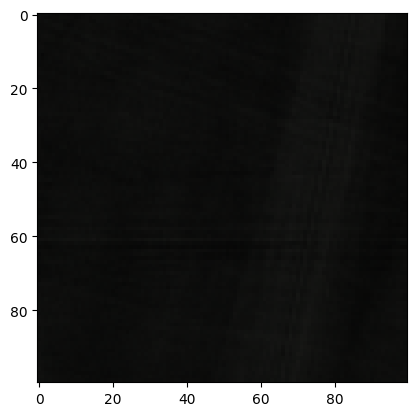

Iteration 100: Loss = 0.065535


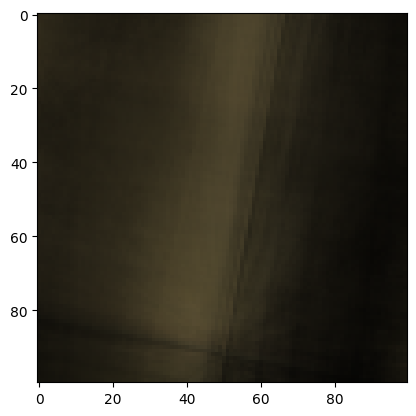

Iteration 200: Loss = 0.078934


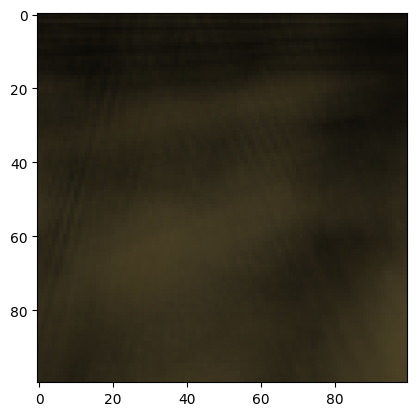

Iteration 300: Loss = 0.092400


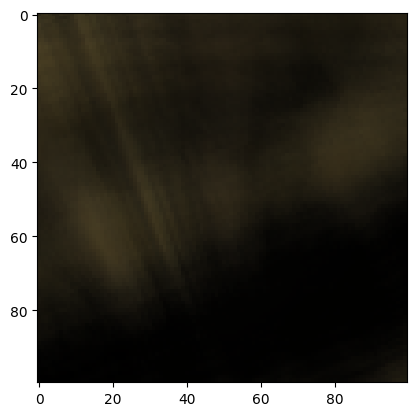

Iteration 400: Loss = 0.045212


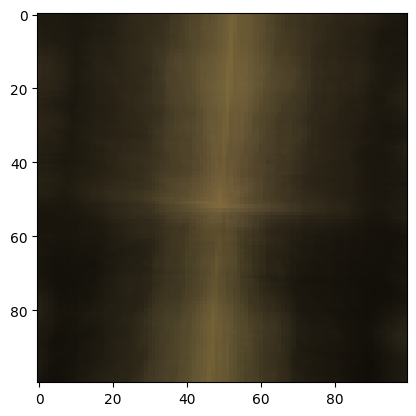

Iteration 500: Loss = 0.055482


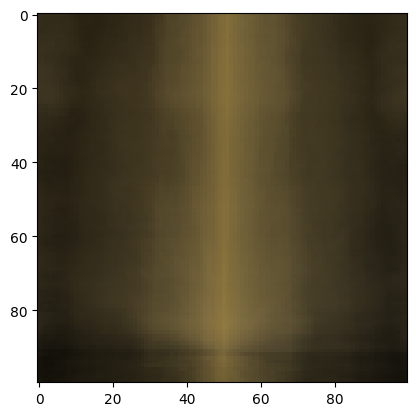

Iteration 600: Loss = 0.036922


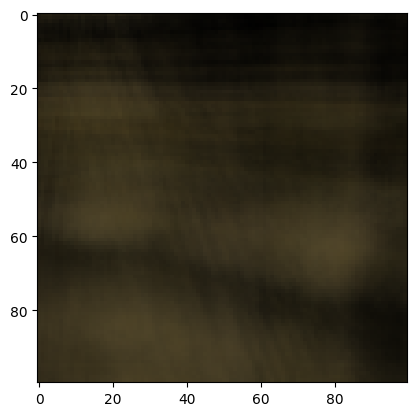

Iteration 700: Loss = 0.040484


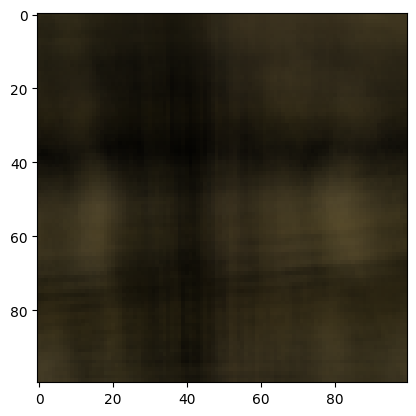

Iteration 800: Loss = 0.050175


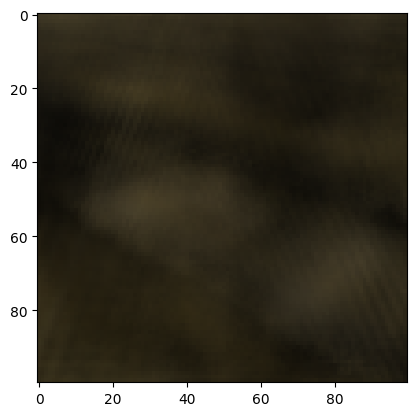

Iteration 900: Loss = 0.042961


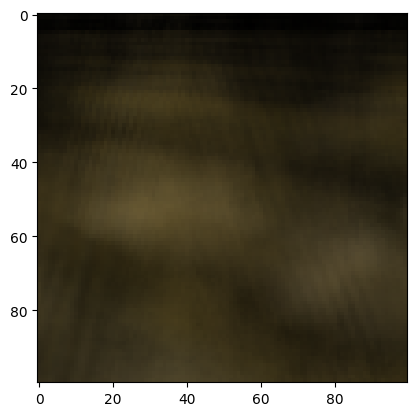

In [951]:
model, losses = train(
    model_type=NerfModel,
    images=input_images,  
    poses=input_poses,  
    focal_length=focal_length,
    learning_rate=5e-6,
    n_iterations=10000,
)